In [5]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Galaxy Color Distribution

In [6]:
# load sample selection
from astropy.table import Table
fpath = '../../data/SDSS_Main/'
fname = 'sdss_vagc.hdf5'
t = Table.read(fpath+fname, path='data')

# define cosmology
from galaxy_shapes.sdss_measurements.default_cosmology import cosmo
#from astropy.cosmology import FlatLambdaCDM
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05, Tcmb0=2.7255)

# sample absolute magnitude limit as a function of redshift
from astro_utils.magnitudes import absolute_magnitude_lim
z = np.linspace(0.001,0.5,100)
Mr_lim = absolute_magnitude_lim(z, 17.77, cosmo=cosmo)

# see Yang et al. (2009) eq. 3, 4, and 5
from galaxy_shapes.sdss_measurements.sdss_utils import maximum_redshift
mm = np.linspace(-24,-16,1000) # sample magnitudes
zz = maximum_redshift(mm) # returns redshift limit

# define (g-r) color
color = np.array(t['ABSMAG_g0.1'] - t['ABSMAG_r0.1'])

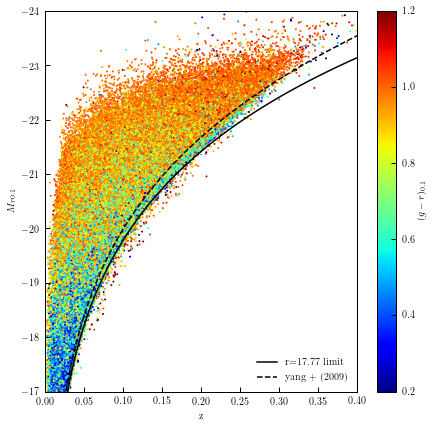

In [7]:
# magnitude vs redshift

fig = plt.figure(figsize=(7,7))
plt.scatter(t['Z'], t['ABSMAG_r0.1'],
            s=1, c=color, vmin=0.2, vmax=1.2, cmap='jet')
l1, = plt.plot(z, Mr_lim, '-', color='black')
l2, = plt.plot(zz, mm, '--', color='black')
plt.xlim([0,0.4])
plt.ylim([-17,-24])
plt.xlabel('z')
plt.ylabel(r'$M_{r0.1}$')
plt.colorbar(label=r'$(g-r)_{0.1}$')
plt.legend([l1,l2],['r=17.77 limit','yang + (2009)'],
           loc='lower right', fontsize=10, frameon=False)
plt.show()

In [8]:
# make completeness cut
from galaxy_shapes.sdss_measurements.estimate_completeness import z_lim
zz = maximum_redshift(t['ABSMAG_r0.1'], cosmo=cosmo)
comp_mask = (t['Z'] <= zz) & (t['ABSMAG_r0.1']<0) & (t['ABSMAG_r0.1']-t['ABSMAG_r0.1']<1.5)
t=t[comp_mask]
color = color[comp_mask]

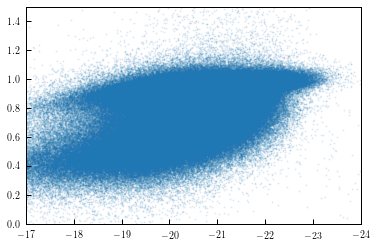

In [37]:
plt.scatter(t['ABSMAG_r0.1'], color, s=1, alpha=0.1)
plt.ylim([0,1.5])
plt.xlim([-17,-24])
plt.show()

## Measure Color Distribution

In [9]:
mag_bins = np.arange(-23,-16.9,0.2)[::-1]
mag_bin_centers = (mag_bins[:-1]+mag_bins[1:])/2.0
color_bins = np.arange(0,1.4,0.05)
xsample=np.linspace(0,1.5,1000)

In [10]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
gmm = GaussianMixture(n_components=2, means_init=[[0.3],[1.0]],
                      covariance_type='spherical', precisions_init=[1.0/0.1**2, 1.0/0.1**2])

0 1767 True
1 2227 True
2 2680 True
3 3229 True
4 3866 True
5 4524 True
6 5599 True
7 6536 True
8 8172 True
9 9935 True
10 12416 True
11 15670 True
12 19505 True
13 23302 True
14 26062 True
15 29052 True
16 31773 True
17 34621 True
18 36672 True
19 37355 True
20 35593 True
21 32289 True
22 27896 True
23 22652 True
24 16687 True
25 11444 True
26 7363 True
27 4171 True
28 2275 True
29 1113 True


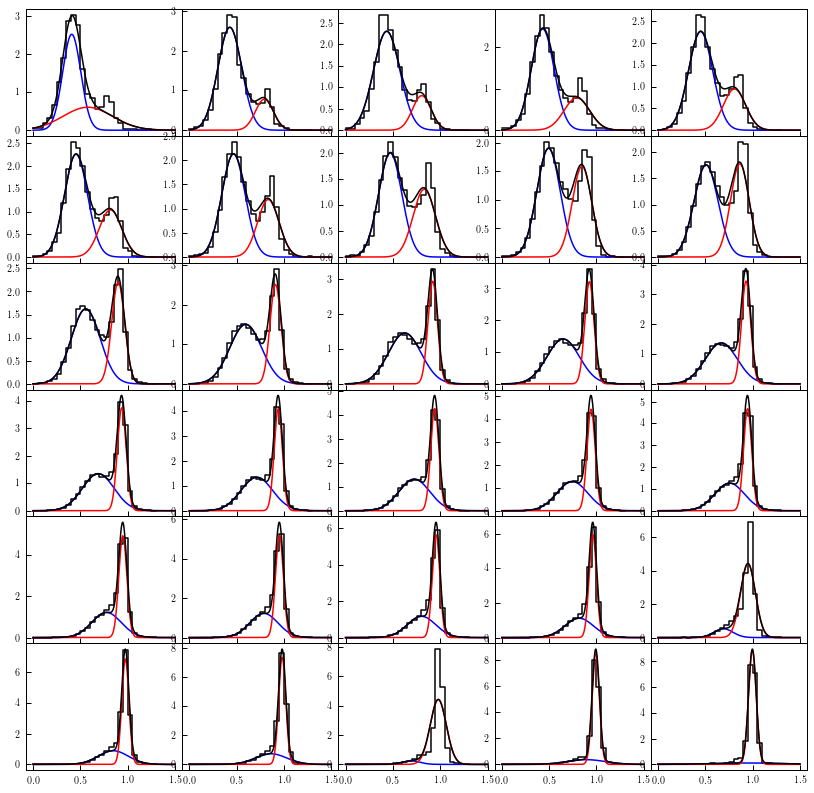

In [11]:
# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

N = len(mag_bins)-1
m1s = np.zeros(N)
m2s = np.zeros(N)
s1s = np.zeros(N)
s2s = np.zeros(N)
fs = np.zeros(N)
for i in range(0,N):
    mask = (t['ABSMAG_r0.1']<mag_bins[i]) & (t['ABSMAG_r0.1']>mag_bins[i+1])
    N = np.sum(mask)
    
    X = color[mask]
    X = X.reshape((N,1))
    res = gmm.fit(X)
    m1, m2 = res.means_
    s1, s2 = np.sqrt((res.covariances_[0], res.covariances_[1]))
    f = res.weights_[0]
    
    m1s[i] = m1
    m2s[i] = m2
    s1s[i] = np.sqrt(s1)
    s2s[i] = np.sqrt(s2)
    fs[i] = f
    
    counts = np.histogram(color[mask], bins=color_bins)[0]
    counts = 1.0*counts/np.sum(counts)/np.diff(color_bins)
    ax = axes[i]
    ax.step(color_bins[:-1], counts, where='post', color='black')
    
    ax.plot(xsample, f*norm.pdf(xsample, loc=m1, scale=s1), color='blue')
    ax.plot(xsample, (1-f)*norm.pdf(xsample, loc=m2, scale=s2), color='red')
    ax.plot(xsample, f*norm.pdf(xsample, loc=m1, scale=s1)+(1-f)*norm.pdf(xsample, loc=m2, scale=s2), color='black')
    
    print(i, N, res.converged_)
    

plt.show()

(-17, -24)

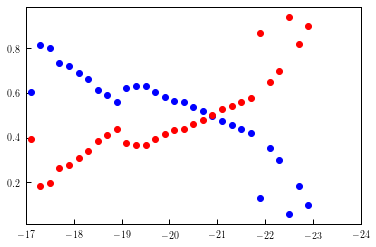

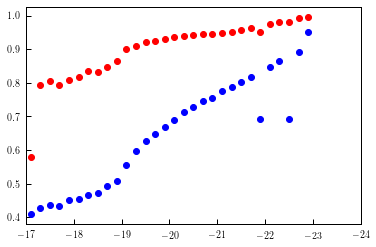

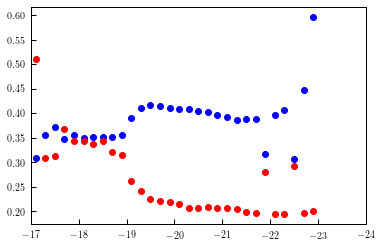

In [12]:
plt.figure()
plt.plot(mag_bin_centers, fs, 'o', color='blue')
plt.plot(mag_bin_centers, 1-fs, 'o', color='red')
plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, m1s, 'o', color='blue')
plt.plot(mag_bin_centers, m2s, 'o', color='red')
plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, s1s, 'o', color='blue')
plt.plot(mag_bin_centers, s2s, 'o', color='red')
plt.xlim([-17,-24])

In [13]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
gmm = GaussianMixture(n_components=3, covariance_type='spherical',tol=10**-4,
                      means_init=[[0.4],[0.7],[0.9]], weights_init=[0.45,0.1,0.45],
                      precisions_init=[1.0/0.4**2, 1.0/0.3**2, 1.0/0.2**2])

In [ ]:
color_model = GalaxyColor()
color_model.params['m1'] = -0.1134652255388035
color_model.params['b1'] = -1.5754936392946468
color_model.params['m2'] = -0.033475839944698944
color_model.params['b2'] = 0.24608502181357306

0 1767 True
1 2227 True
2 2680 True
3 3229 True
4 3866 True
5 4524 True
6 5599 True
7 6536 True
8 8172 True
9 9935 True
10 12416 True
11 15670 True
12 19505 True
13 23302 True
14 26062 True
15 29052 True
16 31773 True
17 34621 True
18 36672 True
19 37355 True
20 35593 True
21 32289 True
22 27896 True
23 22652 True
24 16687 True
25 11444 True
26 7363 False


/Users/duncan/anaconda2/lib/python2.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


27 4171 True
28 2275 True
29 1113 True


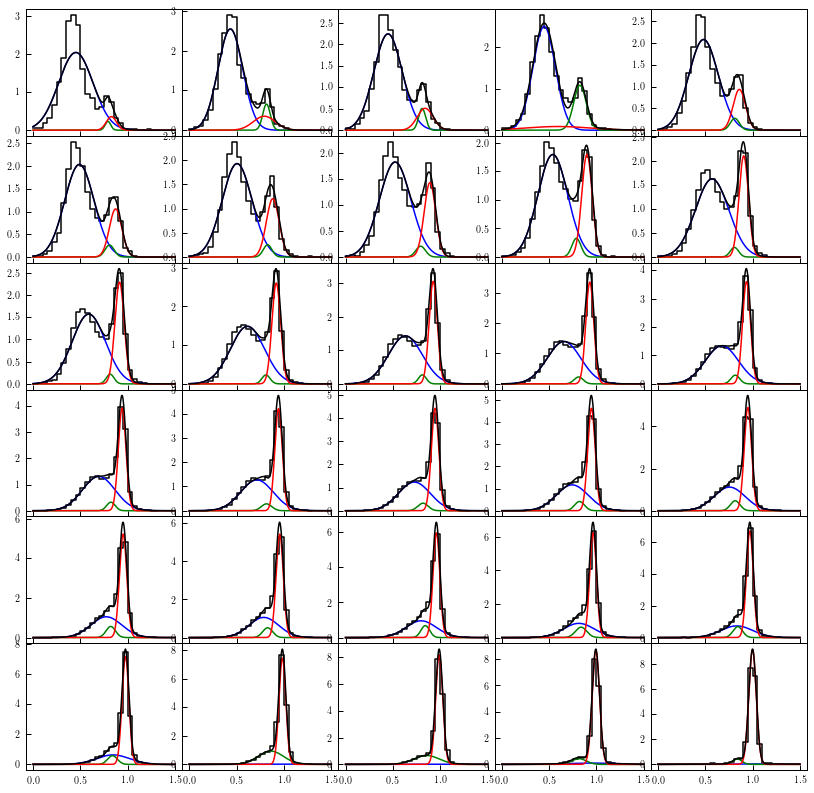

In [26]:
# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

N = len(mag_bins)-1
m1s = np.zeros(N)
m2s = np.zeros(N)
m3s = np.zeros(N)
s1s = np.zeros(N)
s2s = np.zeros(N)
s3s = np.zeros(N)
f1s = np.zeros(N)
f2s = np.zeros(N)
f3s = np.zeros(N)
for i in range(0,N):
    mask = (t['ABSMAG_r0.1']<mag_bins[i]) & (t['ABSMAG_r0.1']>mag_bins[i+1])
    N = np.sum(mask)
    
    # initial params
    f1 = 0.45
    m1 = color_model.lt_mean_color(mag_bin_centers[i])
    s1 = 0.4
    
    f3 = 0.45
    m3 = color_model.et_mean_color(mag_bin_centers[i])
    s3 = 0.2
    
    f2 = 0.1
    m2 = 0.8
    s2 = 0.2
    
    gmm = GaussianMixture(n_components=3, covariance_type='spherical',tol=10**-4,
                      means_init=[[m1],[m2],[m3]], weights_init=[f1,f2,f3],
                      precisions_init=[1.0/s1**2, 1.0/s2**2, 1.0/s3**2])
    
    X = color[mask]
    X = X.reshape((N,1))
    res = gmm.fit(X)
    m1, m2, m3 = res.means_
    s1, s2, s3 = np.sqrt((res.covariances_[0], res.covariances_[1], res.covariances_[2]))
    f1, f2, f3 = (res.weights_[0], res.weights_[1], res.weights_[2])
    
    m1s[i] = m1
    m2s[i] = m2
    m3s[i] = m3
    s1s[i] = np.sqrt(s1)
    s2s[i] = np.sqrt(s2)
    s3s[i] = np.sqrt(s3)
    f1s[i] = f1
    f2s[i] = f2
    f3s[i] = f3
    
    counts = np.histogram(color[mask], bins=color_bins)[0]
    counts = 1.0*counts/np.sum(counts)/np.diff(color_bins)
    ax = axes[i]
    ax.step(color_bins[:-1], counts, where='post', color='black')
    
    ax.plot(xsample, f1*norm.pdf(xsample, loc=m1, scale=s1), color='blue')
    ax.plot(xsample, f2*norm.pdf(xsample, loc=m2, scale=s2), color='green')
    ax.plot(xsample, f3*norm.pdf(xsample, loc=m3, scale=s3), color='red')
    y = f1*norm.pdf(xsample, loc=m1, scale=s1) +\
        f2*norm.pdf(xsample, loc=m2, scale=s2) +\
        f3*norm.pdf(xsample, loc=m3, scale=s3)
    ax.plot(xsample, y, color='black')
    
    print(i, N, res.converged_)
    

plt.show()

(-17, -24)

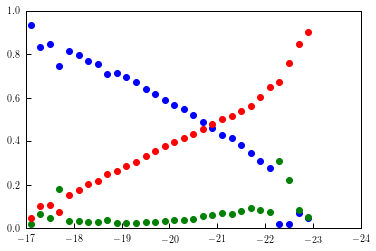

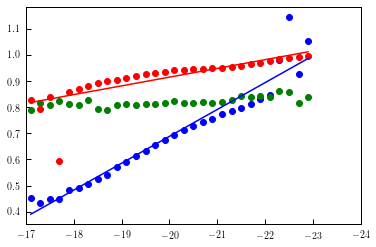

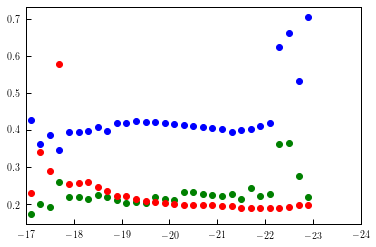

In [29]:
color_model = GalaxyColor()
color_model.params['m1'] = -0.10301207163024402
color_model.params['b1'] = -1.371778653581658
color_model.params['m2'] = -0.033475839944698944
color_model.params['b2'] = 0.24608502181357306

plt.figure()
plt.plot(mag_bin_centers, f1s, 'o', color='blue')
plt.plot(mag_bin_centers, f2s, 'o', color='green')
plt.plot(mag_bin_centers, f3s, 'o', color='red')
plt.ylim([0,1])
plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, m1s, 'o', color='blue')
plt.plot(mag_bin_centers, m2s, 'o', color='green')
plt.plot(mag_bin_centers, m3s, 'o', color='red')

plt.plot(mag_bin_centers, color_model.lt_mean_color(mag_bin_centers), '-', color='blue')
plt.plot(mag_bin_centers, color_model.et_mean_color(mag_bin_centers), '-', color='red')

plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, s1s, 'o', color='blue')
plt.plot(mag_bin_centers, s2s, 'o', color='green')
plt.plot(mag_bin_centers, s3s, 'o', color='red')
plt.xlim([-17,-24])

In [16]:
from galaxy_shapes.shape_models.color_model_components import GalaxyColor

In [23]:
color_model = GalaxyColor()
color_model.params['m1'] = -0.1134652255388035
color_model.params['b1'] = -1.5754936392946468
color_model.params['m2'] = -0.033475839944698944
color_model.params['b2'] = 0.24608502181357306

In [28]:
from scipy.stats import linregress
linregress(mag_bin_centers, m3s)
linregress(mag_bin_centers, m1s)

LinregressResult(slope=-0.10301207163024402, intercept=-1.371778653581658, rvalue=-0.9656153361247469, pvalue=6.408006694256888e-18, stderr=0.005241270914419805)

In [21]:
c

0.848650140818154